In [6]:
#pyspark packages
# from pyspark.sql.types import *
# from pyspark.sql.functions import *
# from pyspark.sql import Window, DataFrame
# from pyspark.ml.feature import StandardScaler, VectorAssembler, MinMaxScaler
# from pyspark.ml.linalg import Vectors

# #petastorm packages (to convert pyspark to pytorch)
# from petastorm.spark import SparkDatasetConverter, make_spark_converter
# from petastorm import TransformSpec

# #torch packages
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.autograd import Variable
# import horovod.torch as hvd
# torch.manual_seed(3)
# import mlflow.pytorch
# import mlflow

#other ml packages
#from sparkdl import HorovodRunner
from sklearn.model_selection import train_test_split
#from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK
#from sklearn.metrics import mean_squared_error, explained_variance_score, median_absolute_error, mean_gamma_deviance

#python packages
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt

In [10]:
import pymc3

ImportError: No module named 'pymc3'

## BlipTrack Outlook and Clustering

In [ ]:
def bliptrack_func(airport, terminal, begin_date, end_date):
  airport_table_name = 'DW.vAirports'
  airport_table = spark.read \
              .format("jdbc") \
              .option("url", url) \
              .option("dbtable", airport_table_name) \
              .option("user", username) \
              .option("password", password) \
              .option('dateFormat', 'MM-dd-yyyy') \
              .load()
  
  terminal_table_name = 'DW.vTerminal'
  terminal_table = spark.read \
            .format("jdbc") \
            .option("url", url) \
            .option("dbtable", terminal_table_name) \
            .option("user", username) \
            .option("password", password) \
            .option('dateFormat', 'MM-dd-yyyy') \
            .load()
  
  table_name = 'BT.[vPeopleCounterMessage]'
  terminal = "Terminal {}".format(terminal)
  bliptrack = spark.read \
              .format("jdbc") \
              .option("url", url) \
              .option("dbtable", table_name) \
              .option("user", username) \
              .option("password", password) \
              .option('dateFormat', 'MM-dd-yyyy') \
              .load()
  
  start = datetime.strptime(begin_date, "%Y-%m-%d")
  end = datetime.strptime(end_date, "%Y-%m-%d")
  diff = ((end - start).days) * 24
  df_dates = pd.date_range(begin_date, periods = diff, freq = 'H').tolist()
  df_dates = list(map(pd.Timestamp.to_pydatetime, df_dates))
  df_dates = spark.createDataFrame(df_dates, TimestampType(), ['Date', 'Hour'])
  df_dates = df_dates.withColumn("Date", df_dates["value"].cast(DateType())).withColumn("Hour", hour(col('value'))).drop('value').withColumn('DoW', dayofweek(col('Date')))
  
  bliptrack_counts = bliptrack.filter(bliptrack['TimestampDate'] >= begin_date) \
                                  .select('AirportId', 'TerminalId', 'TimestampDate', 'TimestampTime', 'peoplecount')
  
  bliptrack_counts = bliptrack_counts.withColumn("peoplecount", bliptrack_counts['peoplecount'].cast(IntegerType()))
  bliptrack_counts = bliptrack_counts.withColumn("Hour", hour(col('TimestampTime'))).drop("TimestampTime")
  bliptrack_counts = bliptrack_counts.withColumn("Date", col('TimestampDate')).drop("TimestampDate")
  
  bliptrack_counts = bliptrack_counts.join(terminal_table, bliptrack_counts['TerminalId'] == terminal_table['Id'], "inner")
  bliptrack_counts = bliptrack_counts.filter(bliptrack_counts['Terminal Code'] == terminal).select('Date', 'Hour', 'peoplecount')
  bliptrack_counts = bliptrack_counts.na.fill(value = 0)
  
  bliptrack_counts = bliptrack_counts.select('Date', 'Hour', 'peoplecount').groupBy('Date', 'Hour').sum('peoplecount').withColumn('People Count', col('sum(peoplecount)')).drop('sum(peoplecount)')
  
  df_to_return = df_dates.join(bliptrack_counts, ['Date', 'Hour'], how = 'left')
  
  return(df_to_return)

In [ ]:
df_bliptrack = bliptrack_func('EWR', 'B', '2020-11-30', '2021-04-13')

In [ ]:
df_bliptrack = df_bliptrack.sort('Date', 'Hour').na.fill(value=0)
pandas_df = df_bliptrack.toPandas()

In [ ]:
pandas_df['People Count'] = pandas_df['People Count'] / 10000

Out[7]:

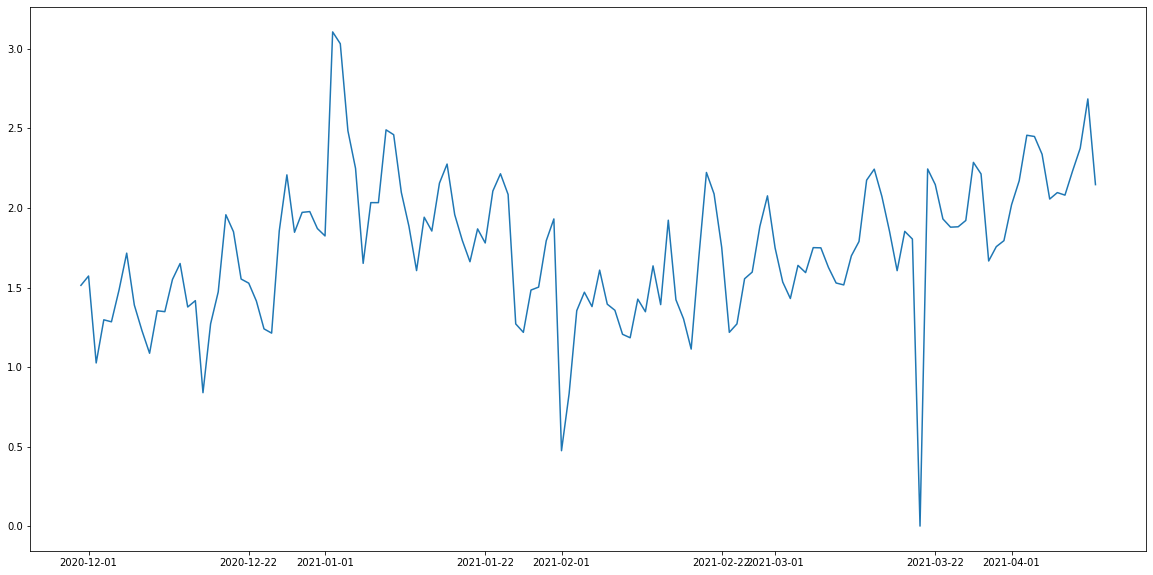

[<matplotlib.lines.Line2D at 0x7f287da7bed0>]

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(pandas_df.groupby('Date').sum()['People Count'])

In [ ]:
dates = pandas_df.Date.unique()
timeseries = []
for date in dates:
  curr_list = list(pandas_df.loc[pandas_df['Date'] == date]['People Count'])
  timeseries.append(curr_list)

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
# km = TimeSeriesKMeans(n_clusters=3, metric="dtw")
timeseries_for_ts = to_time_series_dataset(timeseries)

/databricks/python/lib/python3.7/site-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
 "Scikit-learn <0.24 will be deprecated in a "

In [ ]:
km = TimeSeriesKMeans(n_clusters=4, verbose=True, random_state=2)
y_pred = km.fit_predict(timeseries_for_ts)

0.037 --> 0.026 --> 0.025 --> 0.025 --> 0.025 --> 0.024 --> 0.024 --> 0.024 --> 0.024 --> 0.024 --> 0.024 -->

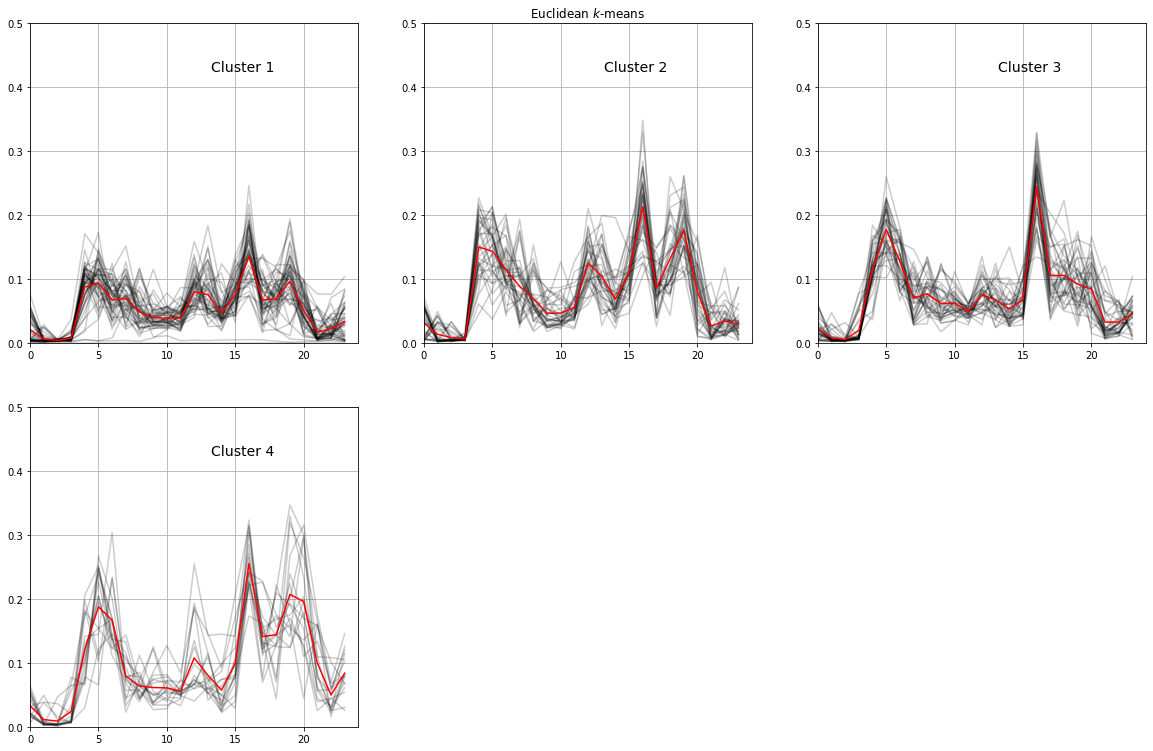

In [ ]:
sz = timeseries_for_ts.shape[1]
plt.figure(figsize = (20,20))
plot_list = []
for yi in range(4):
  
    plt.subplot(3, 3, yi+1)
    for xx in timeseries_for_ts[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 0.5)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes, fontsize = 14)
    plt.grid(True)
    if yi == 1:
        plt.title("Euclidean $k$-means") 

In [ ]:
pandas_grouped_date = pandas_df.groupby('Date').sum().reset_index()
pandas_grouped_date['DoW'] = pandas_grouped_date['Date'].apply(lambda x: x.strftime("%A"))
pandas_grouped_date['Cluster'] = y_pred
pandas_grouped_date['Cluster'] = pandas_grouped_date['Cluster'] + 1
pandas_grouped_date['Month'] = pandas_grouped_date['Date'].apply(lambda x: x.strftime("%B"))

In [ ]:
for i in range(1,5):
  print('Cluster {}'.format(i))
  print('Average Passenger Count: {}'.format(int((pandas_grouped_date.loc[pandas_grouped_date['Cluster'] == i]['People Count'].mean())*10000)))
  month_counts = pandas_grouped_date.loc[pandas_grouped_date['Cluster'] == i]['Month'].value_counts()
  for month in month_counts.index:
    print("Month: {}\t\t Count: {}".format(month, month_counts[month]))

  print("  ")  
  day_of_week = pandas_grouped_date.loc[pandas_grouped_date['Cluster'] == i]['DoW'].value_counts()
  for dow in day_of_week.index:
    print("DoW: {}\t\t Count: {}".format(dow, day_of_week[dow]))
  print("  ")
  print(" ------------ ")

Cluster 1
Average Passenger Count: 12980
Month: December Count: 21
Month: February Count: 19
Month: January Count: 4
Month: March Count: 2
Month: November Count: 1
 
DoW: Wednesday Count: 9
DoW: Thursday Count: 9
DoW: Tuesday Count: 9
DoW: Friday Count: 7
DoW: Monday Count: 6
DoW: Saturday Count: 5
DoW: Sunday Count: 2
 
 ------------ 
Cluster 2
Average Passenger Count: 19629
Month: January Count: 21
Month: December Count: 9
Month: February Count: 3
Month: March Count: 1
 
DoW: Saturday Count: 7
DoW: Monday Count: 7
DoW: Sunday Count: 6
DoW: Thursday Count: 4
DoW: Tuesday Count: 4
DoW: Wednesday Count: 3
DoW: Friday Count: 3
 
 ------------ 
Cluster 3
Average Passenger Count: 18065
Month: March Count: 23
Month: April Count: 6
Month: February Count: 4
Month: January Count: 2
Month: December Count: 1
 
DoW: Wednesday Count: 7
DoW: Friday Count: 7
DoW: Monday Count: 7
DoW: Thursday Count: 6
DoW: Tuesday Count: 6
DoW: Sunday Count: 2
DoW: Saturday Count: 1
 
 ------------ 
Cluster 4
Average Passenger Count: 23953
Month: April Count: 6
Month: March Count: 5
Month: January Count: 4
Month: February Count: 2
 
DoW: Sunday Count: 9
DoW: Saturday Count: 6
DoW: Friday Count: 2
 
 ------------

In [ ]:
month_counts = pandas_grouped_date.loc[pandas_grouped_date['Cluster'] == 1]['Month'].value_counts()
for month in month_counts.index:
  print("Month: {}\t\t Count: {}".format(month, month_counts[month]))
  
day_of_week = pandas_grouped_date.loc[pandas_grouped_date['Cluster'] == 1]['DoW'].value_counts()
for dow in day_of_week.index:
  print("DoW: {}\t\t Count: {}".format(dow, day_of_week[dow]))

Month: January Count: 9
Month: February Count: 2
Month: March Count: 2
Month: December Count: 1
DoW: Saturday Count: 6
DoW: Sunday Count: 6
DoW: Monday Count: 1
DoW: Tuesday Count: 1

In [ ]:
pandas_grouped_date.loc[pandas_grouped_date['Month'] == 'April']

Out[15]:

,Date,Hour,DoW,People Count,Cluster,Month
122,2021-04-01,276,Thursday,2.0204,3,April
123,2021-04-02,276,Friday,2.1711,4,April
124,2021-04-03,276,Saturday,2.4570,4,April
125,2021-04-04,276,Sunday,2.4492,4,April
126,2021-04-05,276,Monday,2.3375,3,April
127,2021-04-06,276,Tuesday,2.0562,3,April
128,2021-04-07,276,Wednesday,2.0968,3,April
129,2021-04-08,276,Thursday,2.0808,3,April
130,2021-04-09,276,Friday,2.2327,4,April
131,2021-04-10,276,Saturday,2.3754,4,April


## Seats Outlook and Clustering

In [ ]:
# This should return 2 dataframes: domestic hourly/daily, international hourly/daily
def hourly_daily_seats(airport, terminal, begin_date, end_date):
  
  start = datetime.strptime(begin_date, "%Y-%m-%d")
  end = datetime.strptime(end_date, "%Y-%m-%d")
  diff = ((end - start).days) * 24
  df_dates = pd.date_range(begin_date, periods = diff, freq = 'H').tolist()
  df_dates = list(map(pd.Timestamp.to_pydatetime, df_dates))
  df_dates = spark.createDataFrame(df_dates, TimestampType(), ['Date', 'Hour'])
  date_table = df_dates.withColumn("Date", df_dates["value"].cast(DateType())).withColumn("Hour", hour(col('value'))).drop('value').withColumn('DoW', dayofweek(col('Date')))
  
  
  table_name = "FS.[vFlight Schedule]"
  
  flight_schedule = spark.read \
              .format("jdbc") \
              .option("url", url) \
              .option("dbtable", table_name) \
              .option("user", username) \
              .option("password", password) \
              .option('dateFormat', 'MM-dd-yyyy') \
              .load()
  
  domestic_seats = flight_schedule.filter(flight_schedule['Dep Airport Code'] == airport) \
                                  .filter(flight_schedule['Dep Terminal'] == terminal) \
                                  .filter(flight_schedule['Flight Date'] >= begin_date) \
                                  .filter(flight_schedule['Flight Date'] < end_date) \
                                  .filter(flight_schedule['International Domestic'] == 'Domestic') \
                                  .select(["Flight Date", "Flight Date Time", "Seats"])
  domestic_seats = domestic_seats.withColumn("Domestic Seats", domestic_seats['Seats'].cast(IntegerType()))
  domestic_seats = domestic_seats.withColumn("Hour", hour(col('Flight Date Time')))
  
  domestic_seats_daily = domestic_seats.groupBy('Flight Date').sum('Domestic Seats').select(col('sum(Domestic Seats)').alias('Domestic_Daily_Seats'), col('Flight Date').alias('Date'))
  domestic_seats_hourly = domestic_seats.groupBy(['Flight Date', 'Hour']).sum('Domestic Seats').select(col('sum(Domestic Seats)').alias('Domestic_Hourly_Seats'), col('Flight Date').alias('Date'), col('Hour').alias('Hour'))
  
  domestic_seats_daily = domestic_seats_daily.join(date_table, ['Date'], 'left')
  domestic_seats = domestic_seats_hourly.join(domestic_seats_daily, ['Date', 'Hour'], "right")
  
  international_seats = flight_schedule.filter(flight_schedule['Dep Airport Code'] == airport) \
                                  .filter(flight_schedule['Dep Terminal'] == terminal) \
                                  .filter(flight_schedule['Flight Date'] >= begin_date) \
                                  .filter(flight_schedule['Flight Date'] < end_date) \
                                  .filter(flight_schedule['International Domestic'] == 'International') \
                                  .select(["Flight Date", "Flight Date Time", "Seats"])
  
  international_seats = international_seats.withColumn("International Seats", international_seats['Seats'].cast(IntegerType()))
  international_seats = international_seats.withColumn("Hour", hour(col('Flight Date Time')))
  
  international_seats_daily = international_seats.groupBy('Flight Date').sum('International Seats').select(col('sum(International Seats)').alias('International_Daily_Seats'), col('Flight Date').alias('Date'))
  international_seats_hourly = international_seats.groupBy(['Flight Date', 'Hour']).sum('International Seats').select(col('sum(International Seats)').alias('International_Hourly_Seats'), col('Flight Date').alias('Date'), col('Hour').alias('Hour'))
  
  international_seats_daily = international_seats_daily.join(date_table, ['Date'], 'left')
  international_seats = international_seats_hourly.join(international_seats_daily, ['Date', 'Hour'], "right")
  
  df_totals = date_table.join(domestic_seats, ['Date', 'Hour', 'DoW'], "inner").join(international_seats, ['Date', 'Hour', 'DoW'], 'inner')
  df_totals = df_totals.na.fill(value = 0)
  
  df_totals = df_totals.withColumn('Percent_Domestic_Seats', col('Domestic_Hourly_Seats') / col('Domestic_Daily_Seats')) \
                       .withColumn('Percent_International_Seats', col('International_Hourly_Seats') / col('International_Daily_Seats'))
  
  windowval = (Window.partitionBy('Date').orderBy('Hour')
             .rangeBetween(Window.unboundedPreceding, 0))
  df_totals = df_totals.withColumn('Domestic_Cum_Sum', sum('Percent_Domestic_Seats').over(windowval)).withColumn('International_Cum_Sum', sum('Percent_International_Seats').over(windowval))
  
  return(df_totals)

In [ ]:
df_seats = hourly_daily_seats('JFK', 5, '2020-11-30', '2021-03-14')

In [ ]:
pandas_seats = df_seats.toPandas()
pandas_seats['Hourly Seats'] = pandas_seats['Domestic_Hourly_Seats'] + pandas_seats['International_Hourly_Seats']
pandas_seats['Hourly Seats'] = pandas_seats['Hourly Seats'] / 10000
pandas_seats['Domestic_Hourly_Seats'] = pandas_seats['Domestic_Hourly_Seats'] / 10000
pandas_seats['International_Hourly_Seats'] = pandas_seats['International_Hourly_Seats'] / 10000
pandas_seats_grouped = pandas_seats.groupby('Date').sum().reset_index()

In [ ]:
def cluster_data(field, clusters):
  dates = pandas_seats.Date.unique()
  timeseries_seats = []
  for date in dates:
    curr_list = list(pandas_seats.loc[pandas_df['Date'] == date][field])
    timeseries_seats.append(curr_list)
    
  timeseries_for_seats = to_time_series_dataset(timeseries_seats)
  km_seats = TimeSeriesKMeans(n_clusters=clusters, verbose=True, random_state=2)
  y_pred_seats = km_seats.fit_predict(timeseries_for_seats)
  
  sz = timeseries_for_seats.shape[1]
  plt.figure(figsize = (20,20))
  plot_list = []
  for yi in range(clusters):

      plt.subplot(3, 3, yi+1)
      for xx in timeseries_for_seats[y_pred_seats == yi]:
          plt.plot(xx.ravel(), "k-", alpha=.2)
      plt.plot(km_seats.cluster_centers_[yi].ravel(), "r-")
      plt.xlim(0, sz)
      plt.ylim(0, 0.28)
      plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
               transform=plt.gca().transAxes, fontsize = 14)
      plt.grid(True)
      if yi == 1:
          plt.title("Euclidean $k$-means") 
          
  cluster_field = field + ' Cluster'
  pandas_seats_grouped['DoW'] = pandas_seats_grouped['Date'].apply(lambda x: x.strftime("%A"))
  pandas_seats_grouped[cluster_field] = y_pred_seats
  pandas_seats_grouped[cluster_field] = pandas_seats_grouped[cluster_field] + 1
  pandas_seats_grouped['Month'] = pandas_seats_grouped['Date'].apply(lambda x: x.strftime("%B"))
  
  for i in range(1,clusters+1):
    print('Cluster {}'.format(i))
    print('Average Passenger Count: {}'.format(int((pandas_seats_grouped.loc[pandas_seats_grouped[cluster_field] == i][field].mean())*10000)))
    month_counts = pandas_seats_grouped.loc[pandas_seats_grouped[cluster_field] == i]['Month'].value_counts()
    for month in month_counts.index:
      print("Month: {}\t\t Count: {}".format(month, month_counts[month]))

    print("  ")  
    day_of_week = pandas_seats_grouped.loc[pandas_seats_grouped[cluster_field] == i]['DoW'].value_counts()
    for dow in day_of_week.index:
      print("DoW: {}\t\t Count: {}".format(dow, day_of_week[dow]))
    print("  ")
    print(" ------------ ")
    
    return(pandas_seats_grouped)

### Plot Flight Schedule Seats here

In [ ]:
df_seats = df_seats.filter(df_seats['Date'] > '2021-03-09')
df_seats_pandas = df_seats.toPandas()
df_seats_pandas['Hourly Seats'] = df_seats_pandas['Domestic_Hourly_Seats'] + df_seats_pandas['International_Hourly_Seats']
df_seats_pandas['Est Pax'] = df_seats_pandas['Hourly Seats'] * 0.55

In [ ]:
pandas_df['People Count'] = pandas_df['People Count'] / 10000

In [ ]:
df_merged = df_seats_pandas.merge(pandas_df, on = ['Date', 'Hour'], how = 'left')

In [ ]:
df_merged['Est Pax Shift'] = df_merged['Est Pax'].shift(-2)

In [ ]:
df_merged.dropna(inplace = True)

In [ ]:
df_merged['Absolute Error'] = df_merged['Est Pax Shift'] - df_merged['People Count']
df_merged['Relative Error'] = df_merged['Absolute Error'] / df_merged['People Count']

Out[57]:

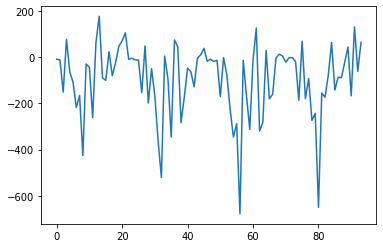

<matplotlib.axes._subplots.AxesSubplot at 0x7f11b5f39290>

In [ ]:
df_merged['Absolute Error'].plot()

In [ ]:
df_merged.describe()

Out[58]:

,Hour,DoW_x,Domestic_Hourly_Seats,Domestic_Daily_Seats,International_Hourly_Seats,International_Daily_Seats,Percent_Domestic_Seats,Percent_International_Seats,Domestic_Cum_Sum,International_Cum_Sum,Hourly Seats,Est Pax,DoW_y,People Count,Est Pax Shift,Absolute Error,Relative Error
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,11.265957,5.468085,332.276596,7814.297872,232.202128,5498.276596,0.042553,0.042193,0.489074,0.518016,564.478723,310.463298,5.468085,407.159574,311.633511,-95.526064,-0.005675
std,6.841014,1.113960,342.665999,1063.003817,232.121195,318.502390,0.043098,0.041933,0.382281,0.357529,506.146282,278.380455,1.113960,343.017329,277.290411,156.887145,2.817560
min,0.000000,4.000000,0.000000,6210.000000,0.000000,5175.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,-679.000000,-1.000000
25%,5.250000,4.250000,0.000000,6541.500000,0.000000,5184.500000,0.000000,0.000000,0.038367,0.127685,162.000000,89.100000,4.250000,125.500000,89.100000,-169.450000,-0.770307
50%,11.000000,5.000000,300.000000,8693.000000,200.000000,5213.000000,0.034310,0.034880,0.519939,0.584187,520.500000,286.275000,5.000000,363.000000,286.275000,-55.025000,-0.249383
75%,17.000000,6.000000,518.000000,8769.500000,400.000000,5734.000000,0.063251,0.069952,0.877420,0.851547,860.000000,473.000000,6.000000,568.750000,473.000000,-1.250000,-0.021056
max,23.000000,7.000000,1345.000000,8795.000000,880.000000,5905.000000,0.178477,0.149026,1.000000,1.000000,2063.000000,1134.650000,7.000000,1378.000000,1134.650000,178.100000,26.500000


## Plot

In [ ]:
import seaborn as sns

0.005 --> 0.003 --> 0.003 --> 0.003 --> 0.003 --> 0.003 --> 
Cluster 1
Average Passenger Count: 4999
Month: January Count: 11
Month: December Count: 7
Month: February Count: 3
 
DoW: Friday Count: 7
DoW: Monday Count: 6
DoW: Saturday Count: 5
DoW: Thursday Count: 2
DoW: Tuesday Count: 1
 
 ------------ 
0.003 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 
Cluster 1
Average Passenger Count: 5510
Month: January Count: 16
Month: December Count: 11
Month: February Count: 1
 
DoW: Saturday Count: 6
DoW: Sunday Count: 4
DoW: Wednesday Count: 4
DoW: Tuesday Count: 4
DoW: Monday Count: 4
DoW: Friday Count: 3
DoW: Thursday Count: 3
 
 ------------

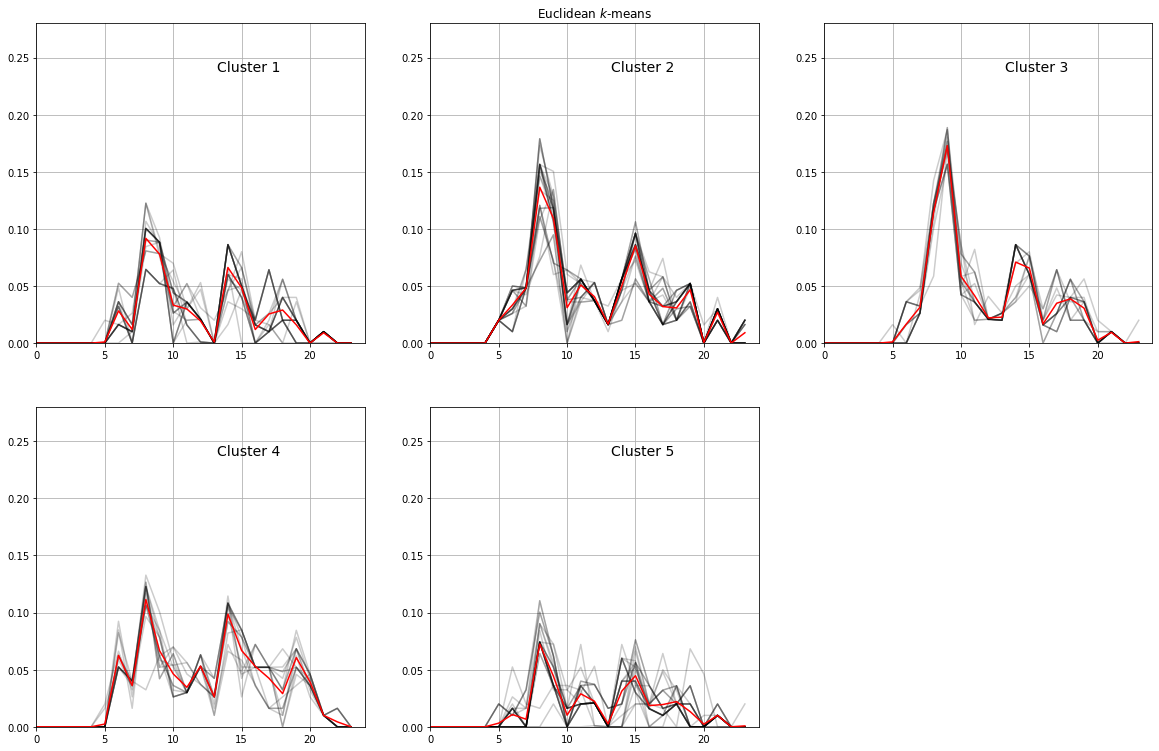

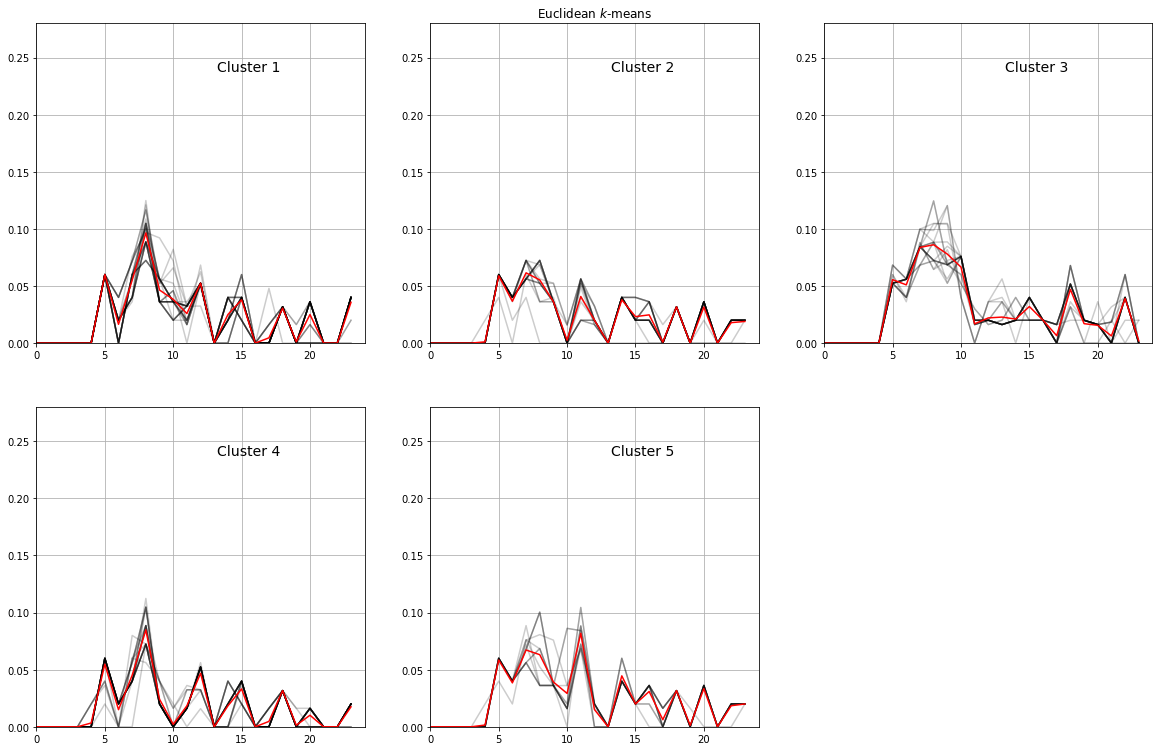

In [ ]:
domestic_data = cluster_data('Domestic_Hourly_Seats', 5)
international_data = cluster_data('International_Hourly_Seats', 5)

In [ ]:
merged_data = domestic_data.merge(international_data, on = ['Date'], how = 'inner')
merged_data = merged_data.merge(pandas_grouped_date, on = ['Date'], how = 'inner')

In [ ]:
merged_data.columns

Out[24]: Index(['Date', 'Hour_x', 'DoW_x', 'Domestic_Hourly_Seats_x',
 'Domestic_Daily_Seats_x', 'International_Hourly_Seats_x',
 'International_Daily_Seats_x', 'Percent_Domestic_Seats_x',
 'Percent_International_Seats_x', 'Domestic_Cum_Sum_x',
 'International_Cum_Sum_x', 'Hourly Seats_x',
 'Domestic_Hourly_Seats Cluster_x', 'Month_x',
 'International_Hourly_Seats Cluster_x', 'Hour_y', 'DoW_y',
 'Domestic_Hourly_Seats_y', 'Domestic_Daily_Seats_y',
 'International_Hourly_Seats_y', 'International_Daily_Seats_y',
 'Percent_Domestic_Seats_y', 'Percent_International_Seats_y',
 'Domestic_Cum_Sum_y', 'International_Cum_Sum_y', 'Hourly Seats_y',
 'Domestic_Hourly_Seats Cluster_y', 'Month_y',
 'International_Hourly_Seats Cluster_y', 'Hour', 'DoW', 'People Count',
 'Cluster', 'Month'],
 dtype='object')

In [ ]:
merged_data = merged_data[['Date', 'International_Hourly_Seats Cluster_x', 'Domestic_Hourly_Seats Cluster_x','International_Hourly_Seats Cluster_y', 'Domestic_Hourly_Seats Cluster_y', 'Cluster', 'Hourly Seats_x', 'DoW_x', 'Month', 'People Count']]

In [ ]:
merged_data

Out[26]:

,Date,International_Hourly_Seats Cluster_x,Domestic_Hourly_Seats Cluster_x,International_Hourly_Seats Cluster_y,Domestic_Hourly_Seats Cluster_y,Cluster,Hourly Seats_x,DoW_x,Month,People Count
0,2020-11-30,4,3,4,3,1,1.3154,Monday,November,0.4911
1,2020-12-01,4,1,4,1,1,1.0676,Tuesday,December,0.4984
2,2020-12-02,2,5,2,5,1,0.8886,Wednesday,December,0.4876
3,2020-12-03,4,3,4,3,3,1.2472,Thursday,December,0.5823
4,2020-12-04,4,1,4,1,1,0.9826,Friday,December,0.5214
...,...,...,...,...,...,...,...,...,...,...
99,2021-03-09,2,2,2,2,1,1.0961,Tuesday,March,0.5118
100,2021-03-10,2,2,2,2,3,1.1423,Wednesday,March,0.7502
101,2021-03-11,2,2,2,2,2,1.4529,Thursday,March,1.0401
102,2021-03-12,2,2,2,2,2,1.3868,Friday,March,1.0737


Out[27]:

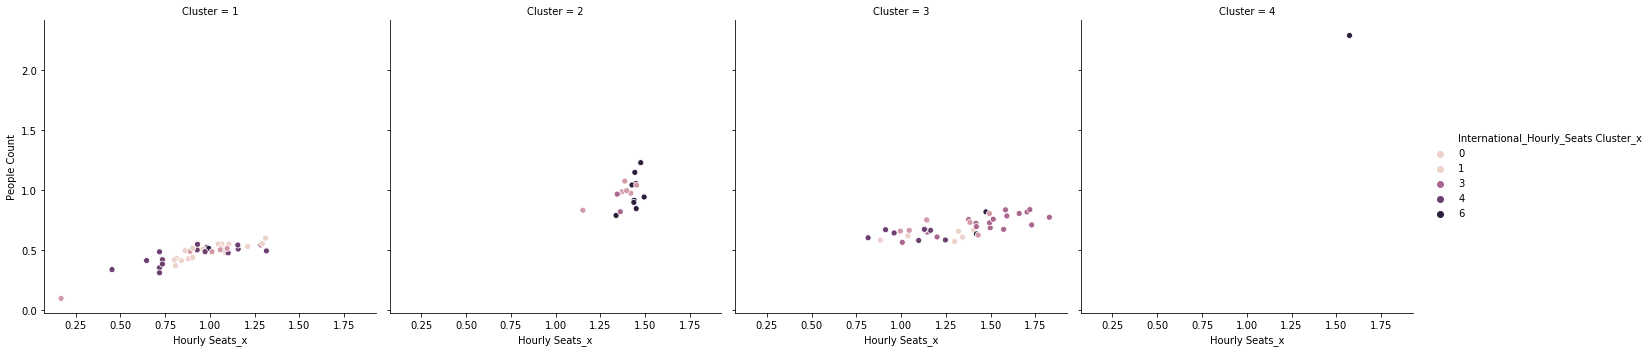

<seaborn.axisgrid.FacetGrid at 0x7fe98091edd0>

In [ ]:
sns.relplot(x="Hourly Seats_x", y="People Count", col="Cluster", hue = 'International_Hourly_Seats Cluster_x', data=merged_data)

In [ ]:
dates = pandas_seats.Date.unique()
timeseries_seats = []
for date in dates:
  curr_list = list(pandas_seats.loc[pandas_df['Date'] == date]['Hourly Seats'])
  timeseries_seats.append(curr_list)

In [ ]:
timeseries_for_seats = to_time_series_dataset(timeseries_seats)
km_seats = TimeSeriesKMeans(n_clusters=5, verbose=True, random_state=2)
y_pred_seats = km_seats.fit_predict(timeseries_for_seats)

0.010 --> 0.007 --> 0.007 --> 0.007 --> 0.007 -->

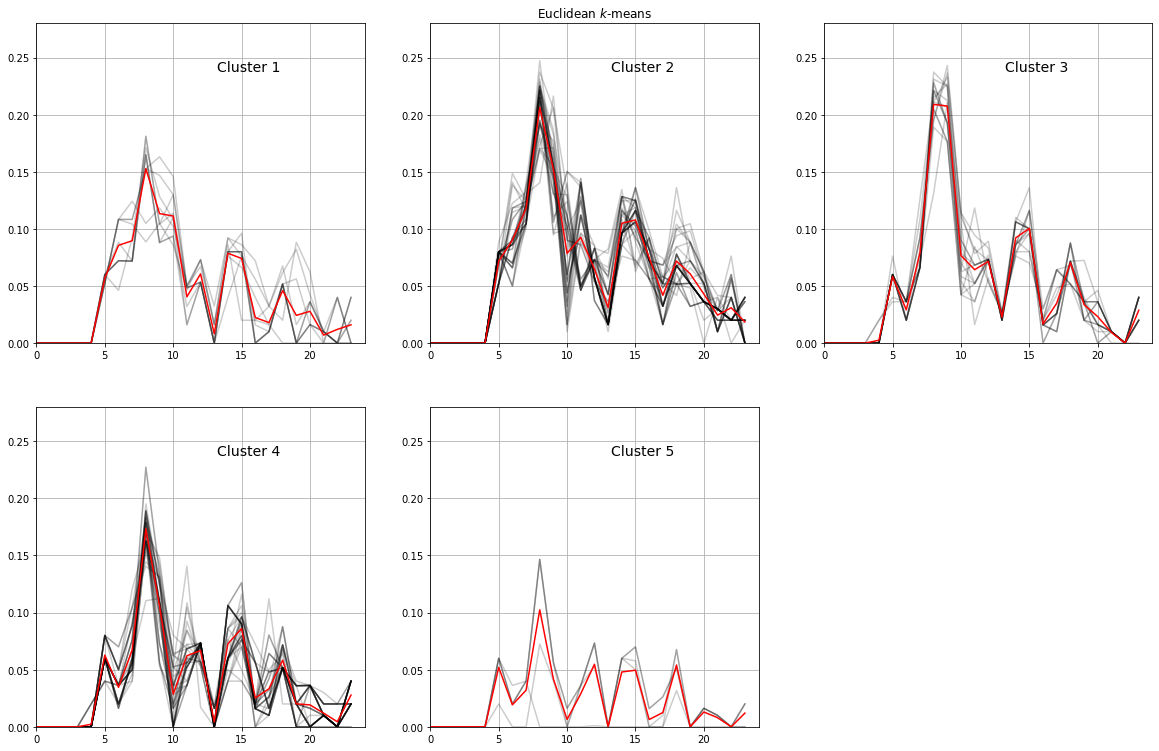

In [ ]:
sz = timeseries_for_seats.shape[1]
plt.figure(figsize = (20,20))
plot_list = []
for yi in range(5):
  
    plt.subplot(3, 3, yi+1)
    for xx in timeseries_for_seats[y_pred_seats == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km_seats.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 0.28)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes, fontsize = 14)
    plt.grid(True)
    if yi == 1:
        plt.title("Euclidean $k$-means") 

In [ ]:
pandas_seats_grouped['DoW'] = pandas_seats_grouped['Date'].apply(lambda x: x.strftime("%A"))
pandas_seats_grouped['Cluster'] = y_pred_seats
pandas_seats_grouped['Cluster'] = pandas_seats_grouped['Cluster'] + 1
pandas_seats_grouped['Month'] = pandas_seats_grouped['Date'].apply(lambda x: x.strftime("%B"))

In [ ]:
for i in range(1,5):
  print('Cluster {}'.format(i))
  print('Average Passenger Count: {}'.format(int((pandas_seats_grouped.loc[pandas_seats_grouped['Cluster'] == i]['Hourly Seats'].mean())*10000)))
  month_counts = pandas_seats_grouped.loc[pandas_seats_grouped['Cluster'] == i]['Month'].value_counts()
  for month in month_counts.index:
    print("Month: {}\t\t Count: {}".format(month, month_counts[month]))

  print("  ")  
  day_of_week = pandas_seats_grouped.loc[pandas_seats_grouped['Cluster'] == i]['DoW'].value_counts()
  for dow in day_of_week.index:
    print("DoW: {}\t\t Count: {}".format(dow, day_of_week[dow]))
  print("  ")
  print(" ------------ ")

Cluster 1
Average Passenger Count: 10449
Month: January Count: 5
Month: December Count: 4
Month: February Count: 1
 
DoW: Saturday Count: 6
DoW: Thursday Count: 2
DoW: Friday Count: 2
 
 ------------ 
Cluster 2
Average Passenger Count: 14841
Month: February Count: 14
Month: December Count: 11
Month: March Count: 9
Month: January Count: 3
 
DoW: Saturday Count: 8
DoW: Sunday Count: 7
DoW: Monday Count: 7
DoW: Friday Count: 6
DoW: Thursday Count: 5
DoW: Wednesday Count: 2
DoW: Tuesday Count: 2
 
 ------------ 
Cluster 3
Average Passenger Count: 12301
Month: January Count: 8
Month: December Count: 5
Month: February Count: 2
Month: November Count: 1
 
DoW: Thursday Count: 8
DoW: Sunday Count: 7
DoW: Monday Count: 1
 
 ------------ 
Cluster 4
Average Passenger Count: 9670
Month: January Count: 13
Month: December Count: 11
Month: February Count: 8
Month: March Count: 4
 
DoW: Wednesday Count: 13
DoW: Tuesday Count: 9
DoW: Friday Count: 7
DoW: Monday Count: 6
DoW: Saturday Count: 1
 
 ------------